In [1]:
# https://github.com/bcsrn/RL_DDPG_Recommendation
# https://github.com/bcsrn/RL_DDPG_Recommendation/blob/master/RL_ActorCritic_DDPG_Movie_Recommendation.ipynb

# An implementation of this paper: https://arxiv.org/pdf/1810.12027.pdf

In [2]:
# Install 
! pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


## Import dependencies

In [3]:
#Dependencies
import pandas as pd
from IPython.display import display
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import itertools
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
# from torchtools.optim import Ranger
from tqdm import tqdm
#import tqdm
import random
import matplotlib.pyplot as plt
#uncomment to use adam
from torch.optim import Adam
from sklearn.metrics.pairwise import cosine_similarity as cs
import seaborn as sns

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preperation
1. Read the ratings, users and movies from the dataset.
2. Create dataframes for ratings, movies and 

In [4]:
ratings_list = [i.strip().split("::") for i in open(r'Dataset/MovieLens1M/ratings.dat', 'r').readlines()]

In [5]:
#Loading datasets
ratings_list = [i.strip().split("::") for i in open(r'Dataset/MovieLens1M/ratings.dat', 'r').readlines()]
users_list = [i.strip().split("::") for i in open(r'Dataset/MovieLens1M/users.dat', 'r').readlines()]
movies_list = [i.strip().split("::") for i in open(r'Dataset/MovieLens1M/movies.dat',encoding='latin-1').readlines()]

ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
display(ratings_df)
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
display(movies_df)
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)
display(movies_df)

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3369: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  exec(code_obj, self.user_global_ns, self.user_ns)


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [6]:
#print(ratings_list)
#display(ratings_df)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


Create a dataframe table where the users are the rows, and movie_ID column. The value is then the rating by a user of that movie. 
The resulting table is a sparse matrix as most of the elements are zero.

In [7]:
#Create a dataframe table where the users are the rows, and movie_ID column. The value is then the rating by a user of that movie.  
R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
R_df = R_df.astype(int)
display(R_df)

MovieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# might be used in the user dependednt state representation
userids = list(R_df.index.values) #list of userids
idx_to_userids = {i:userids[i] for i in range(len(userids))}
userids_to_idx = {userids[i]:i for i in range(len(userids))}

# list of movie ids
columns = list(R_df)
idx_to_id = {i:columns[i] for i in range(len(columns))}
id_to_idx = {columns[i]:i for i in range(len(columns))}

#to get item embeddings
#R_df[userid][movieid]

## Getting Embeddings of User and Item(Movie Id's)

In [9]:
# Standardize the Ratings table

R = R_df.values
# Get mean ratings
user_ratings_mean = np.mean(R, axis = 1)
# Remove mean to standardize the data and reshape
R_demeaned = R - user_ratings_mean.reshape(-1, 1)
# R_demeanded is a standardized matrix of the ratings given by users on movies.

print(user_ratings_mean)
print(len(user_ratings_mean))
print(R_demeaned.shape)
print(R_demeaned)

[0.05990286 0.44522396 0.06206152 ... 0.03184026 0.15002698 0.35429034]
6040
(6040, 3706)
[[ 4.94009714 -0.05990286 -0.05990286 ... -0.05990286 -0.05990286
  -0.05990286]
 [ 4.55477604 -0.44522396 -0.44522396 ... -0.44522396 -0.44522396
  -0.44522396]
 [-0.06206152 -0.06206152 -0.06206152 ... -0.06206152 -0.06206152
  -0.06206152]
 ...
 [ 3.96815974 -0.03184026 -0.03184026 ... -0.03184026 -0.03184026
  -0.03184026]
 [-0.15002698 -0.15002698 -0.15002698 ... -0.15002698 -0.15002698
  -0.15002698]
 [-0.35429034 -0.35429034 -0.35429034 ... -0.35429034 -0.35429034
  -0.35429034]]


In [10]:
#Movie Embeddings
# svds is a sklearn function that computes the smallest or largest k values in the matrix
# It is used on sparse matrices (most values are zero) to calculate the smallest or largest values.
U, s, Vt = svds(R_demeaned, k = 100)

# Vt is a Unitary matrix where right singular vectors are the rows
#print(Vt.shape)
V = Vt.transpose()
print(V.shape)

movie_list = V.tolist()
#print(len(movie_list))
#print(movie_list[0])

# Dictionaries with user and movie embeddings
movie_embeddings_dict = {columns[i]:np.array(movie_list[i],dtype=np.float32) for i in range(len(columns))}
user_list = U.tolist()
user_embeddings_dict =  {userids[i]:np.array(user_list[i],dtype=np.float32) for i in range(len(userids))}

(3706, 100)


In [11]:
#prepare_dataset
#using ratings_df
users_df = ratings_df.sort_values(["UserID","Timestamp"]).set_index("UserID").fillna(0).drop("Timestamp",axis=1)
users = dict(tuple(users_df.groupby("UserID")))


## Train and Test Dataset

In [12]:
#Getting users with positive rating count greater than 10
# 10 == 'N' positively interacted items
from collections import defaultdict
from collections import Counter
users_dict = defaultdict(dict)
users_id_list = set()
for user_id in users:
    # Get the number of ratings one user has given
    rating_freq = Counter(users[user_id]["Rating"].values)
    #print(rating_freq)
    # If user has given less than 10 ratings with a 4 or 5, the user is not added to the user list
    if rating_freq['4']+rating_freq['5']<10 :
        continue
    else:
        users_id_list.add(user_id)
        users_dict[user_id]["item"] = users[user_id]["MovieID"].values
        users_dict[user_id]["rating"] = users[user_id]["Rating"].values


In [13]:
# All the users in the lsit have given more than 10 ratings of either 4 or 5
users_id_list = np.array(list(users_id_list))

In [14]:
#choosing default train_test_split of 25% using sklearns build in function.
train_users,test_users = train_test_split(users_id_list)
print(train_users[:2])

print(test_users[:5])

['1811' '327']
['3136' '1668' '3692' '2291' '2096']


In [15]:
# Class to create custom dataset.
class UserDataset(Dataset):
    def __init__(self,users_list,users_dict):
        self.users_list = users_list
        self.users_dict = users_dict

    def __len__(self):
        return len(self.users_list)

    def __getitem__(self,idx):
        user_id = self.users_list[idx]
        items = [('1',)]*10
        ratings = [('0',)]*10
        j=0
        # Go trough the ratings the user has given. do this until 10 positive ratings have been found.
        for i,rate in enumerate(self.users_dict[user_id]["rating"]):
            # print(f'i: {i}')
            # If the rating is positive eg above 3, and j is less than 10.
            # If this user has given the selected movie a positive rating, add the movie id to the items it returns.
            if int(rate) >3 and j < 10:
                items[j] = self.users_dict[user_id]["item"][i]
                ratings[j] = self.users_dict[user_id]["rating"][i]
                j += 1
        # item = list(self.users_dict[user_id]["item"][:])
        # rating = list(self.users_dict[user_id]["rating"][:])
        size = len(items)
    
        return {'item':items,'rating':ratings,'size':size,'userid':user_id,'idx':idx}

In [16]:
# Create custom dataset
train_users_dataset = UserDataset(train_users,users_dict)
test_users_dataset = UserDataset(test_users,users_dict)

# Create dataLoaders
train_dataloader = DataLoader(train_users_dataset,batch_size=1)
test_dataloader = DataLoader(test_users_dataset,batch_size=1)

train_num = len(train_dataloader)
print(train_num)

# Does not work
#train_num = 3 * train_num
#print(train_num)

4462


# State Representation Models

In [17]:
# Function to create state representation
def drrave_state_rep(userid_b,items,memory,idx):
    user_num = idx
    H = [] # item embeddings
    user_n_items = items
    user_embeddings = torch.Tensor(np.array(user_embeddings_dict[userid_b[0]]),).unsqueeze(0)
    # Add movie embeddings to H and average pool them
    for i,item in enumerate(user_n_items):
        H.append(np.array(movie_embeddings_dict[item[0]]))
    avg_layer = nn.AvgPool1d(1)
    item_embeddings = avg_layer(torch.Tensor(H,).unsqueeze(0)).permute(0,2,1).squeeze(0)
    # Final state, combination of users, user*items and items
    state = torch.cat([user_embeddings,user_embeddings*item_embeddings.T,item_embeddings.T])
    return state # state tensor shape [21,100]


In [18]:
def drru_state_rep(userid_b,items,memory,idx):
    print(f'ddru_state_rep used')
    user_num = idx
    H = []
    user_n_items = items
    user_embeddings = user_embeddings_dict[userid_b[0]]
    for i,item in enumerate(user_n_items):
        ui = np.array(user_embeddings) * np.array(movie_embeddings_dict[item[0]])
        H.append(ui)

    pairs = list(itertools.combinations(memory[user_num], 2))
    for item1,item2 in pairs:
        pair1 =  np.array(movie_embeddings_dict[str(int(item1))])
        pair2 = np.array(movie_embeddings_dict[str(int(item2))])

        product = pair1*pair2
        H.append(product)
    state = torch.Tensor(H,)
    return state #state tensor shape [55,100]

In [19]:
def drrp_state_rep(items,memory,idx):
    print(f'ddrp_state_rep used')
    user_num = idx
    H = []
    user_n_items = items
    for i,item in enumerate(user_n_items):
        H.append(np.array(movie_embeddings_dict[item[0]]))
  
    pairs = list(itertools.combinations(memory[user_num], 2))
    for item1,item2 in pairs:
        pair1 =  np.array(movie_embeddings_dict[str(int(item1))])
        pair2 = np.array(movie_embeddings_dict[str(int(item2))])
        product = pair1*pair2
        H.append(product)
    state = torch.Tensor(H,)
    return state

In [20]:
# just n items and their embeddings used to represent state
def state_rep(item_b):
    state = []
    user_embeddings = np.zeros((len(columns),100))
    movie_ids = list(item[0] for item in item_b)
    for i,subitem in enumerate(user_embeddings):
        if idx_to_id[i] in movie_ids:
            user_embeddings[i] = np.array(movie_embeddings_dict[idx_to_id[i]])
        else:
            user_embeddings[i] = np.zeros((100,))
    state = torch.Tensor(user_embeddings,)
    return torch.reshape(state,[-1])

# Actor, Critic Module

In [21]:
#Actor Model:
#Generating an action a based on state s

class Actor(torch.nn.Module):
    def __init__(self, input_dim, output_dim,hidden_dim):
        super(Actor, self).__init__()

        self.drop_layer = nn.Dropout(p=0.5)        
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, output_dim)


    def forward(self, state):
        # state = self.state_rep(state)
        x = F.relu(self.linear1(state))
        # print(x.shape)
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        # print(x.shape)
        x = self.drop_layer(x)
        # x = torch.tanh(self.linear3(x)) # in case embeds are -1 1 normalized
        x = self.linear3(x) # in case embeds are standard scaled / wiped using PCA whitening
        # return state, x
        return x

In [22]:
class Critic(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_dim):

        super(Critic, self).__init__()

        self.drop_layer = nn.Dropout(p=0.5)

        self.linear1 = nn.Linear(input_dim + output_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)

    def forward(self,state,action):    
        x = torch.cat([state, action], 1)
        # print(x.shape)
        x = F.relu(self.linear1(x))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        x = self.linear3(x)
        return x

In [23]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        # Add the state, action, reward and next state to the replay buffer for this position
        self.buffer[self.position] = (state, action, reward, next_state)
        # Movie the position. increase by one
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        # print(batch)
        state, action, reward, next_state = map(np.stack,zip(*batch))
        return state, action, reward, next_state
    
    def __len__(self):
        return len(self.buffer)


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Store the policy and value loss for plotting
p_loss = []
v_loss = []

cuda


### Hyperparameters

In [25]:
# Hyperparameters.

# Discount factor
discount_factor = 0.6    # balance between the agents focus on immediate and future rewards.
# Learning rate
lr = 0.0001
# Soft update
soft_update = 0.01    # Slowly change the target networks increasing 
# Replay buffer size
replay_buffer_size = 25000    # The size of the cache
# nr of movies to predict/evaluate
nr_to_pred = 10    # The number of movies to predict.

### DDPG training

In [26]:
def ddpg_update(batch_size=1, gamma = discount_factor, min_value = -np.inf, max_value = np.inf, soft_tau = soft_update):
    
    # Get relevant info from the replay buffer. convert to float tensors
    # This function returns a random historical observation from the replay buffer
    state, action, reward, next_state = replay_buffer.sample(batch_size)
    
    state = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)

    action = torch.FloatTensor(action).to(device)
    reward = torch.FloatTensor(reward).to(device)
    # print(state.shape)
    # print(policy_net(state).shape)
    
    # Policy loss is the loss of the actor
    # The policy_loss/actor_loss is the prediction of the value/critic given state and actor/policy predictions.
    # Giving the policy/actor prediction and state to the critic
    policy_loss = value_net(state, policy_net(state))
    #print(f'policy_loss: {policy_loss}')
    policy_loss = -policy_loss.mean()
    #print(f'policy_loss: {policy_loss}')
    p_loss.append(policy_loss)
    
    # next action is what the target policy/ target actor predicts on the next state
    next_action    = target_policy_net(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    # Q = reward + discount * Q next
    expected_value = reward + gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)
    
    # Critic value
    value = value_net(state, action)
    # Value loss is the loss of the critic. Expected value is used to calculate the loss of the critic.
    value_loss = value_criterion(value, expected_value.detach())
    #print(value_loss)
    v_loss.append(value_loss)
    
    # Backpropagation to update the model parameters for the actor using Adam
    policy_optimizer.zero_grad()    # Clears gradients with the Adam optimizer
    policy_loss.backward()          # calculate the derivative of loss using backpropagation
    policy_optimizer.step()         # Take a step based on gradients of the parameters

    # Backpropagation to update the model parameters for the critic using Adam
    value_optimizer.zero_grad()     # Clears gradients with the Adam optimizer
    value_loss.backward()           # calculate the derivative of loss using backpropagation
    value_optimizer.step()          # Take a step based on gradients of the parameters

    # Update the target networks using soft updates
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
                target_param.data.copy_(
                    target_param.data * (1.0 - soft_tau) + param.data * soft_tau
                )
    # Updating the target networks using soft updates
    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

In [27]:
#initializing for drrave state representation
# Input dim, output dim, hidden dim
value_net = Critic(2100,100,256)
#value_net = Critic(5500,100,256)
value_net.to(device=device)
policy_net = Actor(2100,100,256)
#policy_net = Actor(5500,100,256)
policy_net.to(device=device)

target_value_net = Critic(2100,100,256)
#target_value_net = Critic(5500,100,256)
target_value_net.to(device=device)
target_policy_net = Actor(2100,100,256)
#target_policy_net = Actor(5500,100,256)
target_policy_net.to(device=device)

Actor(
  (drop_layer): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=2100, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=100, bias=True)
)

In [28]:
# Set the target models to eval mode
target_policy_net.eval()
target_value_net.eval()

# Initialize the target networks by copying the actor and critic networks
# critic/value and target critic/value together
for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

# actor/policy and target actor/policy
for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)

In [29]:
value_criterion = nn.MSELoss()
value_optimizer = Adam(value_net.parameters(),  lr=lr)
policy_optimizer = Adam(policy_net.parameters(), lr=lr)

print(policy_net)
print(value_net)

Actor(
  (drop_layer): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=2100, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=100, bias=True)
)
Critic(
  (drop_layer): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=2200, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=1, bias=True)
)


In [30]:
# Set the size of the replay buffer to set how much it should remember.
#replay_buffer_size = 10000
#replay_buffer_size = 25000
#replay_buffer_size = 40000
#replay_buffer_size = 5000
#replay_buffer_size = 50000
# Initialize ReplayBuffer Class
replay_buffer = ReplayBuffer(replay_buffer_size)

# The memory is a list with one list per user. per user has 10 movies stored.
# example, memory[userid] is a list with 10 movies for that user.
memory = np.ones((train_num,10))*-1
print(memory)

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


In [31]:
# Function that 
def get_action(state,action_emb,userid_b,item_b,preds):
    action_emb = torch.reshape(action_emb,[1,100]).unsqueeze(0)
    item_embedding = []
    for movie in users_dict[userid_b[0]]["item"]:  
        item_embedding.append(np.array(movie_embeddings_dict[movie]))
    item_embedding = torch.Tensor(item_embedding,)
    items = item_embedding.T.unsqueeze(0)
    m = torch.bmm(action_emb,items).squeeze(0)
    sorted_m,indices = torch.sort(m,descending=True)
    index_list = list(indices[0])
    for i in index_list:
        if users_dict[userid_b[0]]["item"][i] not in preds:
            # Add the movie to predict to the preds and return the index for that movie.
            preds.add(users_dict[userid_b[0]]["item"][i])
            return int(i)


In [32]:
def update_memory(memory,action,idx):
    memory[idx] = list(memory[idx,1:])+[action]

rate = 0

# Training

In [33]:
items = [('1',)]*10
print(items)
print(memory.shape)

[('1',), ('1',), ('1',), ('1',), ('1',), ('1',), ('1',), ('1',), ('1',), ('1',)]
(4462, 10)


In [34]:
preddict = dict()
# Iterate over every rating in the train_loader/train dataset.
it = iter(train_dataloader)
# nr of movies to predict/evaluate
#nr_to_pred = 5
avg_ratings = []

# For the range of len of train_dataloader
for episode in tqdm(range(train_num-1)):
    batch_size= 1
    preds = set()
    ratings = 0
    first = next(it)    # Next item in the dataloader
    item_b,rating_b,size_b,userid_b,idx_b = first['item'],first['rating'],first['size'],first['userid'],first['idx']
    #print(f'item:{item_b}, rating:{rating_b}, size:{size_b}, userid:{userid_b}, idx:{idx_b}')
    # Every user has 10 movies they have rated positively. Loop over them and add them to the memory for this user.
    memory[idx_b] = [item[0] for item in item_b]
    #print(f'memory idx_b: {memory[idx_b]}')
    
    state = drrave_state_rep(userid_b,item_b,memory,idx_b)
    #print(f'state: {state}. State shape: {state.shape}')
    # Recommend/predict 5 movies to the current user
    for j in range(nr_to_pred):# 5
        #print(f'State shape: {state.shape}')
        
        state_rep =  torch.reshape(state,[-1])
        #print(f'State_rep shape: {state_rep.shape}')
        # Give the current state to the policy/actor to get a prediciton. The 
        state_rep = state_rep.to(device=device)
        action_emb = policy_net(state_rep)
        action_emb = action_emb.cpu()
        # Get the action from the predicted action embedding. Find an action/user rating according to the current policy
        action = get_action(state,action_emb,userid_b,item_b,preds)
        #print(f'action: {action}')
        # rate is what the user has scored the movie in the dataset. True value
        rate = int(users_dict[userid_b[0]]["rating"][action])
        ratings += int(rate)
        #print(f'Rate: {rate}')
        #print(f'movie id: {int(users_dict[userid_b[0]]["item"][action])}')
        try:
            # If rate is 5, rating is 1, if rate is 4, rating is 0.5, if rate is 2, rating is -0.5
            ratings = (int(rate)-3)/2
            #print(f'rating is: {ratings}')
        except:
            ratings = 0
        reward = torch.Tensor((ratings,))
        # If reward is bigger than 0, update the memory 
        if reward > 0:
            #print(f'memory idx before: {memory[idx_b]}')
            # Add the movie predicted by the action to the memory, and it also removes one
            update_memory(memory,int(users_dict[userid_b[0]]["item"][action]),idx_b)
            #print(f'memory idx after: {memory[idx_b]}')

        next_state = drrave_state_rep(userid_b,item_b,memory,idx_b)
        next_state_rep = torch.reshape(next_state,[-1])
        # Add this state, action, reward and next state to the replay buffer and update the ddpg.
        replay_buffer.push(state_rep.detach().cpu().numpy(), action_emb.detach().cpu().numpy(), reward, next_state_rep.detach().cpu().numpy())
        if len(replay_buffer) > batch_size:
            # Update the models. The actor, critic, target actor, target critic
            ddpg_update()

        state = next_state
    # Add the predicted movies for this user to predict dictionary.
    preddict[userid_b[0]] = preds
    
    avg_ratings_ = ratings / nr_to_pred
    avg_ratings.append(avg_ratings_)
    


  0%|          | 0/4461 [00:00<?, ?it/s]<ipython-input-17-8f6d76f8487d>:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:200.)
  item_embeddings = avg_layer(torch.Tensor(H,).unsqueeze(0)).permute(0,2,1).squeeze(0)
100%|██████████| 4461/4461 [57:58<00:00,  1.28it/s]  


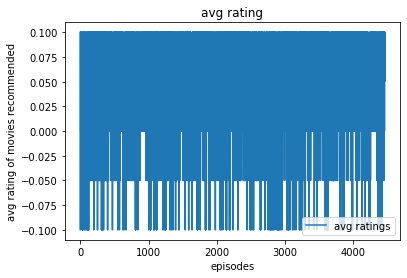

In [35]:
# Plot avg ratings for each user troughout the training
plt.title(f'avg rating')
x = [x for x in range(len(avg_ratings))]
#train_iou_ = [t.item() for t in train_iou]
#test_iou_ = [t.item() for t in test_iou]
plt.plot(x, avg_ratings, label='avg ratings')
#plt.plot(x, test_iou, label='test iou')
plt.xlabel('episodes')
plt.ylabel('avg rating of movies recommended')
plt.legend()
plt.savefig('images/12_ratings.png')
plt.show()
plt.close()

In [36]:
print(train_num)

4462


In [37]:
#print(preddict)
# Example user and predictions
#n_items = take(1, preddict.iteritems())
#print(n_items)

ex_user_with_movies = list(preddict.items())[5]
user = int(ex_user_with_movies[0])
movies = list(ex_user_with_movies[1])
#print(f'User: {user} got reccomended the movies: {movies}')

# Get userID, MovieID and MovieTitle from the idnumbers
user_id = idx_to_userids[user]
movie_id = idx_to_id[int(movies[0])]
#print(f'user_id: {user_id}')
print(f'movie_id: {movie_id}')

# What did the user rate these movies?
#rating = int(users_dict[user]["rating"][int(movie_id)])
#print(f'rating: {rating}')

movie_titles = []
for i in movies:
    #row = movies_df.loc[(movies_df['MovieID'] == int(i))]
    #title = row['Title'].loc[0]
    title = movies_df.loc[movies_df['MovieID'] == int(i), 'Title'].tolist()[0]
    movie_titles.append(title)
    #print(title)
print(f'User: {user} got recommended the movies: {movie_titles}')


movie_id: 1927
User: 2243 got recommended the movies: ['Casablanca (1942)', 'Good Will Hunting (1997)', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)', 'Rain Man (1988)', "Schindler's List (1993)", 'Shawshank Redemption, The (1994)', 'Amadeus (1984)', 'Silence of the Lambs, The (1991)', "One Flew Over the Cuckoo's Nest (1975)", 'Patriot, The (2000)']


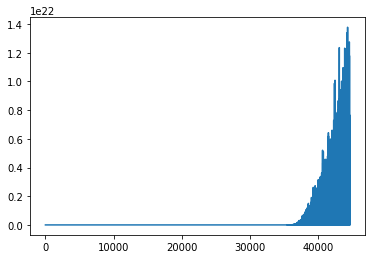

In [38]:
#print(v_loss) Value loss is the critic loss
v_losses= [ loss.detach().cpu().numpy() for loss in v_loss]
#losses= [ loss.detach().numpy() for loss in losses_all]
plt.plot(v_losses)
plt.savefig('images/12_v_loss.png')
plt.show()
plt.close()

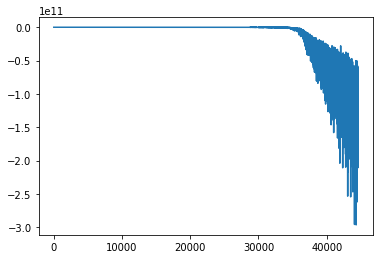

In [39]:
#print(p_loss) Policy loss is the actorr loss
p_losses= [ loss.detach().cpu().numpy() for loss in p_loss]
plt.plot(p_losses)
plt.savefig('images/12_p_loss.png')
plt.show()
plt.close()

# Testing

In [40]:
# https://12ft.io/proxy?q=https%3A%2F%2Ftowardsdatascience.com%2Fnormalized-discounted-cumulative-gain-37e6f75090e9

# Helper function for ndcg
def dcg_score(results):
    dcg = []
    for i, val in enumerate(results):
        #print(val)
        numerator = 2**val - 1
        # Add 2 for python 0-index
        denominator = np.log2(i + 2)
        score = numerator / denominator
        dcg.append(score)
    return sum(dcg)

# Function to evaluate NDCG
def ndcg(results, sorted_results):
    #print(f'results: {results} sorted_results: {sorted_results}')
    #results.astype(numpy.int64)
    #sorted_results..astype(numpy.int64)
    dcg = dcg_score(results)
    idcg = dcg_score(sorted_results)
    #print(f'dcg:{dcg}, idcg:{idcg}')
    ndcg = dcg / idcg
    return ndcg

In [41]:
#prediction algorithm
it2 = iter(test_dataloader)
precision = 0
scores_ = []
test_pred_dict = dict()
for j in tqdm(range(len(test_dataloader)-1)):
    first = next(it2)
    item_b,rating_b,size_b,userid_b,idx_b = first['item'],first['rating'],first['size'],first['userid'],first['idx']
    memory[idx_b] = [item[0] for item in item_b]
    state = drrave_state_rep(userid_b,item_b,memory,idx_b)
    count = 0
    test_pred = set()
    scores = []
    # Loop 5 times for the five movies recommended
    # if a movie is relevant/good recommendation, 
    for j in range(nr_to_pred):#5
        state_rep =  torch.reshape(state,[-1])
        state_rep = state_rep.to(device=device)
        action_emb = policy_net(state_rep)
        action_emb = action_emb.cpu()
        #print(f'action_emb')
        action = get_action(state,action_emb,userid_b,item_b,test_pred)
        rate = int(users_dict[userid_b[0]]["rating"][action])
        try:
            rating = (int(rate)-3)/2
        except:
            rating = 0
        reward = torch.Tensor((rating,))

        if reward > 0:
            count += 1
            update_memory(memory,int(users_dict[userid_b[0]]["item"][action]),idx_b)
        next_state = drrave_state_rep(userid_b,item_b,memory,idx_b)
        state = next_state
        scores.append(int(rate))
        
    # precision for this user is added to the overall precision
    precision += count/nr_to_pred
    test_pred_dict[userid_b[0]] = test_pred
    
    user_ndcg_score = ndcg(scores, sorted(scores, reverse=True))
    #scores_ += user_ndcg_score
    scores_.append(user_ndcg_score)

# NDCG10 score or P@k score
p_score = precision / (len(test_dataloader) - 1)
#ndcg_score = scores_ / (len(test_dataloader) - 1)
ndcg_score = sum(scores_) / (len(scores_))
#print(scores_)
print(f"p@{nr_to_pred}: {p_score}")
print(f'ndcg@{nr_to_pred}: {ndcg_score}')

100%|██████████| 1487/1487 [07:12<00:00,  3.44it/s]

p@10: 0.7393409549428361
ndcg@10: 0.8729007697807428


In [42]:
ex_test_user_with_movies = list(test_pred_dict.items())[5]
user = int(ex_test_user_with_movies[0])
movies = list(ex_test_user_with_movies[1])

# Get userID, MovieID and MovieTitle from the idnumbers
#user_id = idx_to_userids[user]
#movie_id = idx_to_id[int(movies[0])]

movie_titles = []
for i in movies:
    title = movies_df.loc[movies_df['MovieID'] == int(i), 'Title'].tolist()[0]
    movie_titles.append(title)
print(f'User: {user} from the test set got recommended the movies: {movie_titles}')

User: 2198 from the test set got recommended the movies: ['Big (1988)', 'Entrapment (1999)', 'Christmas Story, A (1983)', 'Rain Man (1988)', '101 Dalmatians (1961)', "Bug's Life, A (1998)", 'Groundhog Day (1993)', 'Ghostbusters (1984)', 'Beetlejuice (1988)', 'Fast Times at Ridgemont High (1982)']


In [43]:
#Getting Cosine similarity of recommended items for a particular userid that has been evaluated


def get_cosine_sim(userid):
    test_pred = test_pred_dict[userid]
    for i,item in enumerate(users_dict[userid]["item"]):
        if item in test_pred:
            print(item,":",users_dict[userid]["rating"][i])

    test_embed = []
    for item in test_pred:
        test_embed.append(np.array(movie_embeddings_dict[item]))

    test_embed_array = np.array(test_embed)

    return test_embed_array

1968 : 5
1259 : 4
2804 : 4
2918 : 5
1617 : 5
3435 : 5
541 : 4
913 : 5
2987 : 4
1206 : 5


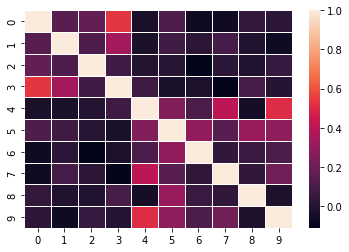

In [44]:
test_embed_array = get_cosine_sim(userid_b[0])
ax = sns.heatmap(cs(test_embed_array), linewidth=0.5)
plt.show()

In [45]:
#print(cs(test_embed_array))

In [46]:
#print(test_embed_array)